In [1]:
import pylab as pl
from scipy.optimize import minimize

from utils import *
from grm_utils import *

---

Read and filter data:

In [2]:
# step 1: read catalogues
xmm12_file = '/Users/ascaife/DATA/MIGHTEE/catalog/XMMLSS/XMMLSS_12/XMMLSS_12_1538856059_1539286252_pol_detections.fits'
xmm12 = read_catalogue(xmm12_file)
xmm13_file = '/Users/ascaife/DATA/MIGHTEE/catalog/XMMLSS/XMMLSS_13/XMMLSS_13_1538942495_1539372679_pol_detections.fits'
xmm13 = read_catalogue(xmm13_file)
xmm14_file = '/Users/ascaife/DATA/MIGHTEE/catalog/XMMLSS/XMMLSS_14/XMMLSS_14_1539028868_1539460932_pol_detections.fits'
xmm14 = read_catalogue(xmm14_file)
cosmos_file = '/Users/ascaife/DATA/MIGHTEE/catalog/COSMOS/COSMOS_1587911796_1524147354_1525613583_pol_detections.fits'
cosmos = read_catalogue(cosmos_file)

In [3]:
# step 2: merge catalogues
mightee = merge_cats([xmm12, xmm13, xmm14, cosmos])
print('# of sources: {}'.format(mightee.shape[0]))

# of sources: 442


In [4]:
# step 3: redshift and galactic latitude filtering
mightee = filter_z(mightee, has_z=True, spec_z=False)
print('# of sources (after z filter): {}'.format(mightee.shape[0]))

# add columns for (l,b)
mightee['l'], mightee['b'] = j2000_to_gal(mightee['ra'].values, mightee['dec'].values)

# filter b<25:
mightee = filter_glat(mightee, bmin=25.)
print('# of sources (after b filter): {}'.format(mightee.shape[0]))

# of sources (after z filter): 313
# of sources (after b filter): 313


---

Make residual RMs:

In [5]:
# step 4: get GRMs
ra = np.array(mightee['ra'].values)
dec= np.array(mightee['dec'].values)

fitsfile = './faradaysky/faraday2020v2.fits'
grmdata, grmhp = get_grm_data(fitsfile) # from grm_utils.py

# nearest pixel values:
grm_fs, grm_fs_std = get_grm(ra, dec, grmdata, grmhp) # from grm_utils.py
mightee['GRM_FS'] = grm_fs
mightee['GRM_FSerr'] = grm_fs_std

# 1 degree median values:
grm1_med, grm1_mad, grm1_std = get_grm1(ra, dec, grmdata, grmhp, r=0.5) # 1 degree median values (grm_utils)
mightee['GRM1'] = grm1_med
mightee['GRM1err'] = grm1_mad

In [6]:
rm      = mightee['RM'].values
grm1    = mightee['GRM1'].values        # use 1 deg median
z       = mightee['best_z'].values

rrm = rm - grm1

std = np.std(rrm)
z = z[np.where(np.abs(rrm)<=2*std)]
rrm = rrm[np.where(np.abs(rrm)<=2*std)]

In [7]:
def bin_rrm(rrm, bins, idx_bin, n_bin):
    
    mu_rrm = [np.average(rrm[idx_bin == j]) for j in range(1, len(bins))]
    sig_rrm= [np.std(rrm[idx_bin == j]) for j in range(1, len(bins))]
    ste_rrm= sig_rrm/np.sqrt(n_bin)
    ste_sig = standard_error_on_stdev(sig_rrm, n_bin)

    return mu_rrm, sig_rrm, ste_rrm, ste_sig

---

Fit filament model to C3 corrected data:


In [8]:
def zdep(rrm, z, model='C1'):
    
    if model=='C1':
        rrm0 = rrm*(1+z)**2
    elif model=='C2':
        rrm0 = rrm*((1+z)**3-1)
        rrm0/= 3*z
    elif model=='C3':
        rrm0 = rrm*(1+z)
    
    return rrm0

In [10]:
bins, idx_bin, n_bin = bin_z(z, nbins=7)
mu_bin = 0.5*np.diff(bins)+bins[:-1]

rrm0 = zdep(rrm, z, model='C3')
mu_rrm_c3, sig_rrm_c3, ste_rrm_c3, ste_sig_c3 = bin_rrm(rrm0, bins, idx_bin, n_bin)

In [11]:
def N_f(z):
    return -1.08*z**2+17.89*z-0.37

In [12]:
# RRM0f fit
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * N_f(x)**0.5 + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0., 1., 0.]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(mu_bin, sig_rrm_c3, ste_sig_c3))
m_ml, b_ml, log_f_ml = soln.x
ih = soln.hess_inv

print("Maximum likelihood estimates:")
print("m = {:.2f}+/-{:.2f}".format(m_ml, np.sqrt(ih[0,0])))
print("b = {:.2f}+/-{:.2f}".format(b_ml, np.sqrt(ih[1,1])))
print("f = {:.2f}+/-{:.2f}".format(np.exp(log_f_ml), np.sqrt(ih[2,2])))

Maximum likelihood estimates:
m = 3.33+/-0.94
b = 3.82+/-3.04
f = 0.18+/-0.40


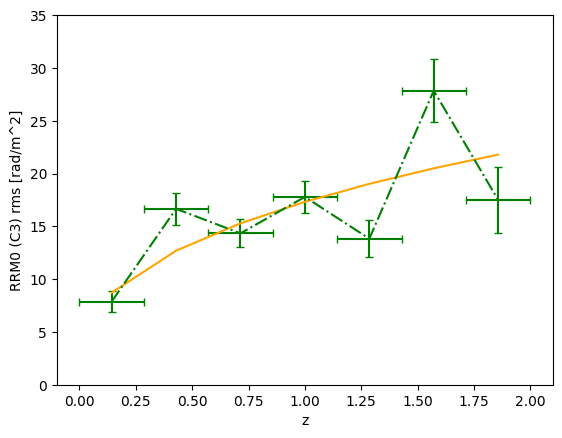

In [13]:
model = m_ml*N_f(mu_bin)**0.5+b_ml
pl.errorbar(mu_bin, sig_rrm_c3, ste_sig_c3, xerr=0.5*np.diff(bins), c='green', ls='dashdot', capsize=3.)
pl.plot(mu_bin, model, c='orange')
pl.xlabel('z')
pl.ylabel('RRM0 (C3) rms [rad/m^2]')
pl.ylim(0,35)
pl.savefig('./plots/mightee_filament.png')
pl.show()

---

Using the relation

$$RM = 0.81 \cdot B_{\Vert} \cdot n_{\rm e} \cdot \ell$$

and correcting for inclination of filaments to the los using

$$\ell = \frac{\pi}{2} d.$$

In [14]:
# b-field calculation

ne = 1e-5
ell = 3e6*(np.pi/2)
B_para = m_ml/(0.81*ne*ell)
B_para_err = np.sqrt(ih[0,0])/(0.81*ne*ell)
print("Magnetic field strength: {:.2f}+/-{:.2f} nG".format(B_para*1e3, B_para_err*1e3))

Magnetic field strength: 87.23+/-24.69 nG
